In [1]:
from tensorflow import keras

# 11.3. 고속 옵티마이저
- 지금까지 알아본 훈련속도 상승 유도 방법
    - 1) 연결 가중치에 좋은 초기화 전략 사용하기
    - 2) 좋은 활성화함수 활용하기
    - 3) 배치 정규화 사용하기
    - 4) Pre-trained 모델의 일부 재사용하기(전이학습)
- 또 다른 방법이 표준격인 SGD 대신 더 빠른 옵티마이저를 이용하는 것
- 가장 인기있는 옵티마이저로는
    - momentum optimization : 모멘텀 최적화
    - Nestrov accelerated gradient : 네스테로프 가속경사
    - AdaGrad
    - RMSProp
    - Adam
    - Nadam 등이 있음

### 11.3.1. 모멘텀 최적화
- 볼링공을 생각하면, 처음에는 느리게 출발하지만, 종단 속도에 도달할 때까지는 빠르게 가속됨
- 반면, 표준 경사하강법은 경사면을 따라 일정하게 조금씩 내려감
    - 즉, 맨 아래 도착하는데 볼링공의 원리와는 다르게 시간이 좀 더 소요될 것
- 기본적인 경사하강법은 가중치에 대한 비용함수 J(theta)의 그래디언트에 학습률 eta를 곱한 것을 바로 차감하여 theta를 갱신함
    - 즉, new_theta = theta - eta * DELTA_theta * J(theta)
    - 이 식의 특징은 이전 그래디언트가 얼마였는지를 고려하지 않는 것임
        - 따라서 국부적으로 그래디언트가 매우 작은 구간에 들어서면, 속도가 매우 느려질 것
- 모멘텀 최적화는 위의 SGD와 달리 **이전 그래디언트의 값**이 중요함
- 매 반복에서 현재 그래디언트에 학습률 eta를 곱하여 **모멘텀 벡터 : m**에 더하고 이 값을 빼는 방식으로 가중치를 갱신함
    - 즉, SGD에서는 그래디언트가 단순히 속도와 연관되는 개념이었지만, 모멘텀 벡터에서는 **가속도**와 연관되는 개념이 됨
- 그런데 이렇게 될 경우 모멘텀 벡터가 지나치게 커질 수 있음
    - 이를 제한하기 위해 일종의 마찰저항 개념인 **모멘텀 : beta**가 등장
        - 이 값은 0 ~ 1사이로 설정되어야하며, 일반적으로는 0.9를 기본으로 함
- 모멘텀 알고리즘은 정리하면 아래와 같음
    - new_m = beta * m - eta * DELTA_theta * J(theta)
    - new_theta = theta + m
- 만약 그래디언트가 일정하다면, 종단 속도는 학습률 eta를 곱한 그래디언트에 1/(1-beta)를 곱한 값과 같음
    - 즉, 예를 들면 beta = 0.9라면, 종단속도는 10이므로, 일반 경사하강법의 10배 빠르게 진행됨
    - 이렇게 되면 그래디언트가 작은 지역을 효과적으로 탈출할 수 있게 됨
- 따라서 골짜기를 따라 최적점에 도달할 때까지 점점 더 빠르게 내려감
- 또한, 배치 정규화를 사용하지 않는 DNN에서 상위층은 종종 스케일이 매우 다른 입력값을 받게 되는데, 모멘텀 최적화를 이용하면 이를 크게 완화할 수 있음
- 그리고 local optimal(지역 최적점)을 건너뛰는데 큰 역할을 함
- 케라스에서 모멘텀을 이용하려면, optimizer로 SGD를 설정하고, momentum인자를 설정해주면 됨

In [2]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9)

- 물론 튜닝할 하이퍼파라미터가 하나 늘어난다는 단점은 있지만, 일반적으로 일반 경사하강법에 비해 훨씬 더 빠른 속도를 보여줌

### 11.3.2. 네스테로프 가속경사
- 모멘텀 최적화의 변종으로, 네스테로프 가속경사(NAG)라고 불림
- 모멘텀 최적화에서는 그래디언트를 현재 위치 theta에서 계산하여 new_theta를 도출함
- 하지만, 네스테로프 모멘텀 최적화에서는 theta + beta*m의 위치에서 비용함수의 그래디언트를 계산함
- 알고리즘은 다음과 같음
    - new_m = beta * m - eta * DELTA_theta * J(theta + beta * m)
    - new_theta = theta + m
- 일반적으로 모멘텀 벡터가 올바른 방향을 가리킬 것이므로, 이런 식의 변경도 가능한 것
- 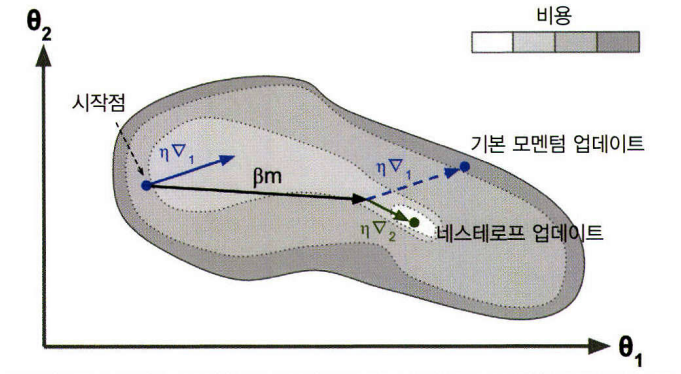

- 위 그림에서 보면, 원래 위치에서 그래디언트를 이용 한 것보다는 올바른 방향으로 조금 더 나아가서 측정한 그래디언트를 사용하는 것이 조금 더 정확할 것
- 그 결과 네스테로프 업데이트가 최적값에 조금 더 가까움
- 시간이 조금 지나면 이 작은 개선들이 쌓여, NAG가 기본 모멘텀 최적화보다 훨씬 더 빠른 속도를 보여주게 됨
- 케라스에서 사용방법은 기본 모멘텀과 비슷하고, nestrov = True 인자를 설정해주면 됨

In [3]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9, nesterov = True)

### 11.3.3. AdaGrad
- 한쪽이 길쭉한 그릇 문제를 생각해보면, 일반 SGD의 경우 전역 최적점 방향으로 곧장 향하지 않음
    - 가장 가파른 경사를 따라 빠르게 내려가기 시작해서 천천히 골짜기 아래로 이동하게 됨
    - 근데, 처음부터 이를 감지하고 전역 최적점쪽으로 잡아당겼다면 더 빠르게 학습이 되었을 것
- 이 문제를 해결하는 것이 **AdaGrad 알고리즘**으로 가장 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시켜서 이 문제를 해결할 수 있게 함
- 알고리즘은 다음과 같음
    - new_s = s + DELTA_theta * J(theta) X Delta_theta * J(theta)
    - new_theta = theta - eta * DELTA_theta * J(theta) %/% sqrt(s + epsilon)
- 첫 단계는 그래디언트의 제곱을 벡터 s에 누적함
    - 이 벡터 식은 벡터 s의 각 원소 s_i마다 s_i <- s_i+(sigma * J(theta) / sigma * theta_i)
        - 즉 s_i는 파라미터 theta_i에 대한 비용함수의 편미분을 제곱하여 누적
        - 비용 함수가 특정 i번째 차원을 따라 가파르다면 특정 s_i는 반복이 진행됨에 따라 점점 더 커질 것
- 두 번째 단계는 경사하강법과 거의 동일
    - 한 가지 큰 차이는 그래디언트 벡터를 sqrt(s+epsilon)으로 나누어 스케일을 조정한다는 점
        - %/%는 원소별 나눗셈을 나타냄
        - epsilon은 분모가 0이 되는것을 막기 위한 값으로 일반적으로 10^-10
        - 이 벡터화된 식은 모든 파라미터 theta_i에 대해 동시에 theta_i <- theta_i - (eta * sigma * J(theta))/(sigma * theta_i) / sqrt(s_1 + epsilon)을 계산하는 것과 동일
- 단순하게 요약하자면, 이 알고리즘은 학습률을 감소시키지만, 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소
    - 이를 **적응적 학습률**이라고 브르며, 전역 최적점 방향으로 좀 더 곧장 가도록 갱신되는데 도움이 됨
- 또한 학습률 파라미터 eta를 덜 튜닝해도 된다는 장점이 있음
    - 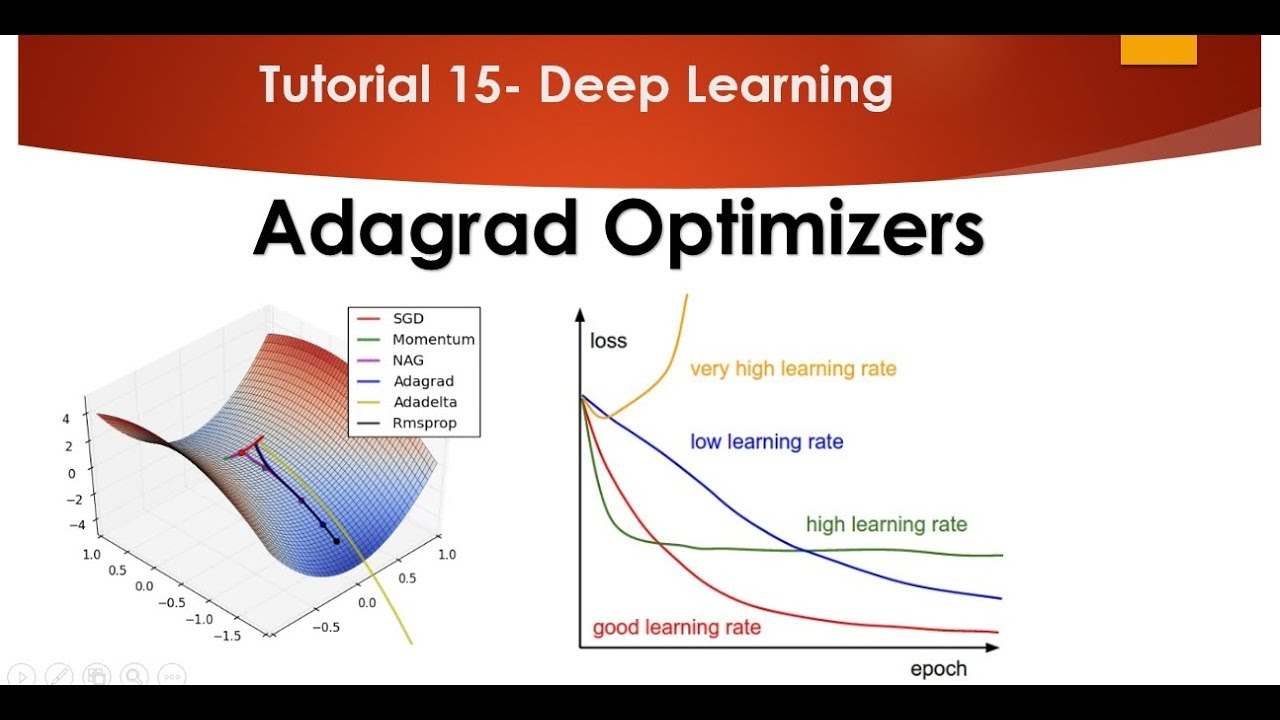
    - https://i.ytimg.com/vi/GSmW59dM0-o/maxresdefault.jpg

- 다만, AdaGrad는 단순한 2차 방정식 문제에 대해서는 잘 작동하지만, 훈련 과정에서 너무 일찍 멈추는 경우가 있음
    - 학습률이 너무 일찍 감소하여 전역 최적점에 도착하기 전에 알고리즘이 완전히 멈춰버리는 것
- 따라서 케라스에 AdaGrad가 있기는 하지만, DNN에는 활용하면 안됨
    - *선형회귀와 같은 단순 작업에는 효과적일 수 있음*

### 11.3.4. RMSProp
- 위에서 다룬 AdaGrad는 너무 빨리 느려져서(lr의 급격한 감소) 전역 최적점에 수렴하지 못하는 위험이 있음
- RMSprop은 AdaGrad의 원리(그래디언트의 누적)를 가져오되, 가장 최근 반복에서 비롯된 그래디언트만 누적하여 이 문제를 해결함
    - 이를 수행하기 위해 알고리즘의 첫 단계에서 **지수감소**를 사용함
- 식은 아래와 같음
    - new_s = beta * s + (1 - beta)DELTA_theta * J(theta) X DELTA_theta * J(theta)
    - new_theta = theta - eta * DELTA_theta * J(theta) %/% sqrt(s + epsilon)
- 새로운 하이퍼파라미터인 beta(감쇠율)가 생김
    - 얘는 보통 0.9로 설정하고, 일반적으로 기본값이 잘 작동하여 굳이 튜닝할 필요는 없는 경우가 대부분임
- 케라스에는 RMSprop옵티마이저가 있음

In [4]:
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9)

- 위 식의 rho 인자가 위 식에서 나온 감쇠율 beta임
- 아주 간단한 문제를 제외하고는 AdaGrad보다 보통 훨씬 좋음
- Adam이 등장하기 전까지 가장 인기있는 옵티마이저였음